# Motor de Recomendación Steam: Content-Based Filtering

**Resumen del Proyecto:**
Este notebook implementa un sistema de recomendación de videojuegos que utiliza **Embeddings de OpenAI** para encontrar similitudes semánticas.

**Flujo de Trabajo:**
1.  **Carga de Datos:** Ingesta de reseñas de usuarios y metadatos enriquecidos.
2.  **Vectorización:** Transformación de descripciones y géneros en vectores.
3.  **Modelo:** Cálculo de similitud para recomendar juegos basándose en el historial positivo del usuario.

**Dataset:**
* Datos de comportamiento: Australian User Reviews.
* Metadatos: Dataset enriquecido mediante la **Steam Store API** (descripciones detalladas, tags, specs).
* Fuente de datos: https://cseweb.ucsd.edu/~jmcauley/datasets.html

In [1]:
!pip install langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 3.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import gzip
import json
import re
import urllib.request
import os
from collections import defaultdict, Counter
from textblob import TextBlob
from openai import OpenAI
from getpass import getpass
from ast import literal_eval

## CONFIGURACIÓN

In [3]:
ARCHIVO_GAMES = 'steam_games_enriched.csv'
ARCHIVO_REVIEWS = 'australian_user_reviews.json'

## CARGA DE DATOS

In [4]:
def load_json_lines(filepath):
    """
    Función auxiliar para leer archivos JSON
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for _, line in enumerate(f):
            data.append(literal_eval(line))

    return pd.DataFrame(data)

In [5]:
# Se cargan el dataset de steam
df_reviews = load_json_lines(ARCHIVO_REVIEWS)
df_metadata_games = pd.read_csv("steam_games_enriched.csv", dtype={'id': str})

## Procesamiento de datos

In [6]:
df_reviews.head(4)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."


In [7]:
# Extracción de reviews del diccionario, para mejorar la exploracion de los datos
df_reviews_plana = pd.DataFrame(columns=['user_id', 'item_id', 'review_text'])

if not df_reviews.empty and 'reviews' in df_reviews.columns:
    df_exploded = df_reviews.explode('reviews').dropna(subset=['reviews'])

    # Extraer item_id y review del diccionario
    df_exploded['item_id'] = df_exploded['reviews'].apply(lambda x: x.get('item_id') if isinstance(x, dict) else None)
    df_exploded['review_text'] = df_exploded['reviews'].apply(lambda x: x.get('review') if isinstance(x, dict) else '')
    df_exploded['recommend'] = df_exploded['reviews'].apply(lambda x: x.get('recommend') if isinstance(x, dict) else None)

    df_reviews_plana = df_exploded[['user_id', 'item_id', 'review_text', 'recommend']].dropna(subset=['item_id'])
    df_reviews_plana['item_id'] = df_reviews_plana['item_id'].astype(str)

    print(f"Reviews procesadas: {len(df_reviews_plana)} reseñas individuales")
else:
    print("No se encontraron reviews para procesar.")

Reviews procesadas: 59305 reseñas individuales


In [8]:
df_reviews_plana.head(2)

,user_id,item_id,review_text,recommend
0,76561197970982479,1250,Simple yet with great replayability. In my opi...,True
0,76561197970982479,22200,It's unique and worth a playthrough.,True


## EXPLORACIÓN DE LOS DATOS

In [9]:
df_reviews_plana.head(4)

,user_id,item_id,review_text,recommend
0,76561197970982479,1250,Simple yet with great replayability. In my opi...,True
0,76561197970982479,22200,It's unique and worth a playthrough.,True
0,76561197970982479,43110,Great atmosphere. The gunplay can be a bit chu...,True
1,js41637,251610,I know what you think when you see this title ...,True


In [10]:
df_metadata_games.head(4)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,detailed_description,short_description
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140,Kotoshiro,NaN,NaN,Monsters appearing one after another. Let's su...,The monsters that are coming up one after anot...
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN,"<span class=""bb_img_ctn""><img class=""bb_img"" s...",Ironbound is a turn-based multiplayer strategy...
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN,"<p class=""bb_paragraph"" >Real Pool 3D (Poolian...",Real Pool 3D (Poolians) is one of the best onl...
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.83,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400,彼岸领域,NaN,NaN,"The author of the first game, a bit special，<b...","The author of the first game, a bit special，Th..."


In [11]:
# Información básica
print(f"\n INFORMACIÓN DEL DATASET: ")
print(f"    Reviews cargadas: {len(df_reviews_plana):,}")
print(f"    VideoJuegos metadata: {len(df_metadata_games):,}")

if not df_reviews_plana.empty:
    print(f"    Usuarios únicos: {df_reviews_plana['user_id'].nunique():,}")
    print(f"    VideoJuegos únicos en reviews: {df_reviews_plana['item_id'].nunique():,}")

# Explorar estructura de datos
print(f"\n ESTRUCTURA DE DATOS:")
print(" Columnas en reviews:")
print(f"   {list(df_reviews_plana.columns)}")
print("\n Columnas en metadata games:")
print(f"   {list(df_metadata_games.columns)}")


 INFORMACIÓN DEL DATASET: 
    Reviews cargadas: 59,305
    VideoJuegos metadata: 32,135
    Usuarios únicos: 25,458
    VideoJuegos únicos en reviews: 3,682

 ESTRUCTURA DE DATOS:
 Columnas en reviews:
   ['user_id', 'item_id', 'review_text', 'recommend']

 Columnas en metadata games:
   ['publisher', 'genres', 'app_name', 'title', 'url', 'release_date', 'tags', 'discount_price', 'reviews_url', 'specs', 'price', 'early_access', 'id', 'developer', 'sentiment', 'metascore', 'detailed_description', 'short_description']


In [12]:
print(f"Tamaño de reviews: {len(df_reviews_plana)}")
conteo_nan_reviews = df_reviews_plana.isnull().sum()
print(conteo_nan_reviews)

print(f"\nTamaño de metadata: {len(df_metadata_games)}")
conteo_nan_metadata = df_metadata_games.isnull().sum()
print(conteo_nan_metadata)

Tamaño de reviews: 59305
user_id        0
item_id        0
review_text    0
recommend      0
dtype: int64

Tamaño de metadata: 32135
publisher                8071
genres                   3283
app_name                    2
title                    2050
url                         0
release_date             2067
tags                      163
discount_price          31910
reviews_url                 2
specs                     670
price                    1377
early_access                0
id                          2
developer                3299
sentiment                7182
metascore               29528
detailed_description     2174
short_description        2169
dtype: int64


## PREPARACIÓN Y LIMPIEZA DE DATOS

In [13]:
from bs4 import BeautifulSoup

In [14]:
# Función para limpiar HTML
def clean_html(text):
    if not isinstance(text, str): return ''
    return BeautifulSoup(text, "html.parser").get_text()

In [15]:
# 1. Limpieza de Metadata de Juegos
metadata_clean = df_metadata_games[['id', 'publisher', 'genres', 'title', 'tags', 'specs', 'detailed_description', 'release_date']].copy()
metadata_clean.columns = ['item_id', 'publisher', 'genres', 'title', 'tags', 'specs', 'detailed_description', 'release_date']

metadata_clean['detailed_description'] = metadata_clean['detailed_description'].apply(clean_html)
metadata_clean = metadata_clean.dropna()

print(f"Originales: {len(df_metadata_games)} filas")
print(f"Después de limpieza: {len(metadata_clean)} filas")

/tmp/ipython-input-3984566919.py:4: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  return BeautifulSoup(text, "html.parser").get_text()


Originales: 32135 filas
Después de limpieza: 23614 filas


In [16]:
# 2. Limpieza de Reviews
reviews_clean = df_reviews_plana[['user_id', 'item_id', 'review_text', 'recommend']].copy()

# Transformar: Steam usa Recomendado (Si/No).
# 1: True -> Recomendado
# 0: False -> No recomendado
reviews_clean["rating"] = reviews_clean["recommend"].astype(int)

reviews_clean = reviews_clean.dropna()

print(f"Originales: {len(df_reviews_plana)} filas")
print(f"Después de limpieza: {len(reviews_clean)} filas")

Originales: 59305 filas
Después de limpieza: 59305 filas


In [17]:
print(f" Datos limpios:")
print(f"    Reviews: {len(reviews_clean):,}")
print(f"    Videojuegos: {len(metadata_clean):,}")

# Análisis de intersección
print(f"\n ANÁLISIS DE INTERSECCIÓN DE DATOS:")
print(f"    IDs Juegos únicos en reviews: {reviews_clean['item_id'].nunique():,}")
print(f"    IDs Juegos únicos en metadata: {metadata_clean['item_id'].nunique():,}")

 Datos limpios:
    Reviews: 59,305
    Videojuegos: 23,614

 ANÁLISIS DE INTERSECCIÓN DE DATOS:
    IDs Juegos únicos en reviews: 3,682
    IDs Juegos únicos en metadata: 23,613


In [18]:
# 3. Intersección (Solo quedarnos con juegos que existen en ambos datasets)
common_items = set(reviews_clean['item_id']) & set(metadata_clean['item_id'])
print(f"IDs comunes: {len(common_items):,}")

if len(common_items) == 0:
    print(" NO HAY INTERSECCIÓN")
else:
    reviews_final = reviews_clean[reviews_clean['item_id'].isin(common_items)]
    metadata_final = metadata_clean[metadata_clean['item_id'].isin(common_items)]

print(f"    Reviews finales: {len(reviews_final):,}")
print(f"    Videojuegos finales: {len(metadata_final):,}")
print(f"    Usuarios únicos: {reviews_final['user_id'].nunique():,}")

IDs comunes: 2,988
    Reviews finales: 49,772
    Videojuegos finales: 2,988
    Usuarios únicos: 23,135


## ANÁLISIS EXPLORATORIO

In [19]:
if len(reviews_final) > 0:
    print(" ESTADÍSTICAS GENERALES:")

    # Como recommend es booleano, el promedio es el % de recomendaciones positivas
    recommend_mean = reviews_final['recommend'].mean() * 100
    recommend_median = reviews_final['recommend'].median()

    print(f"    % de usuarios que recomiendan: {recommend_mean:.1f}%")
    print(f"    Mediana de recommend: {recommend_median}")

    # Valor más común (mode)
    mode_values = reviews_final['recommend'].mode()
    if len(mode_values) > 0:
        print(f"    Valor más común: {mode_values.iloc[0]}")
    else:
        print(f"    Valor más común: N/A")

    # Análisis de actividad
    user_activity = reviews_final.groupby('user_id').size()
    item_popularity = reviews_final.groupby('item_id').size()

    print(f"\n ANÁLISIS DE USUARIOS:")
    print(f"    Promedio reviews por usuario: {user_activity.mean():.1f}")
    print(f"    Máximo reviews por usuario: {user_activity.max()}")
    print(f"    Mínimo reviews por usuario: {user_activity.min()}")

    print(f"\n ANÁLISIS DE PRODUCTOS:")
    print(f"    Promedio reviews por videojuego: {item_popularity.mean():.1f}")
    print(f"    Producto más popular: {item_popularity.max()} reviews")

else:
    print(" No hay datos de reviews para analizar")


 ESTADÍSTICAS GENERALES:
    % de usuarios que recomiendan: 89.4%
    Mediana de recommend: 1.0
    Valor más común: True

 ANÁLISIS DE USUARIOS:
    Promedio reviews por usuario: 2.2
    Máximo reviews por usuario: 20
    Mínimo reviews por usuario: 1

 ANÁLISIS DE PRODUCTOS:
    Promedio reviews por videojuego: 16.7
    Producto más popular: 3759 reviews


/tmp/ipython-input-1765546888.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_final['year'] = pd.to_datetime(metadata_final['release_date'], errors='coerce').dt.year


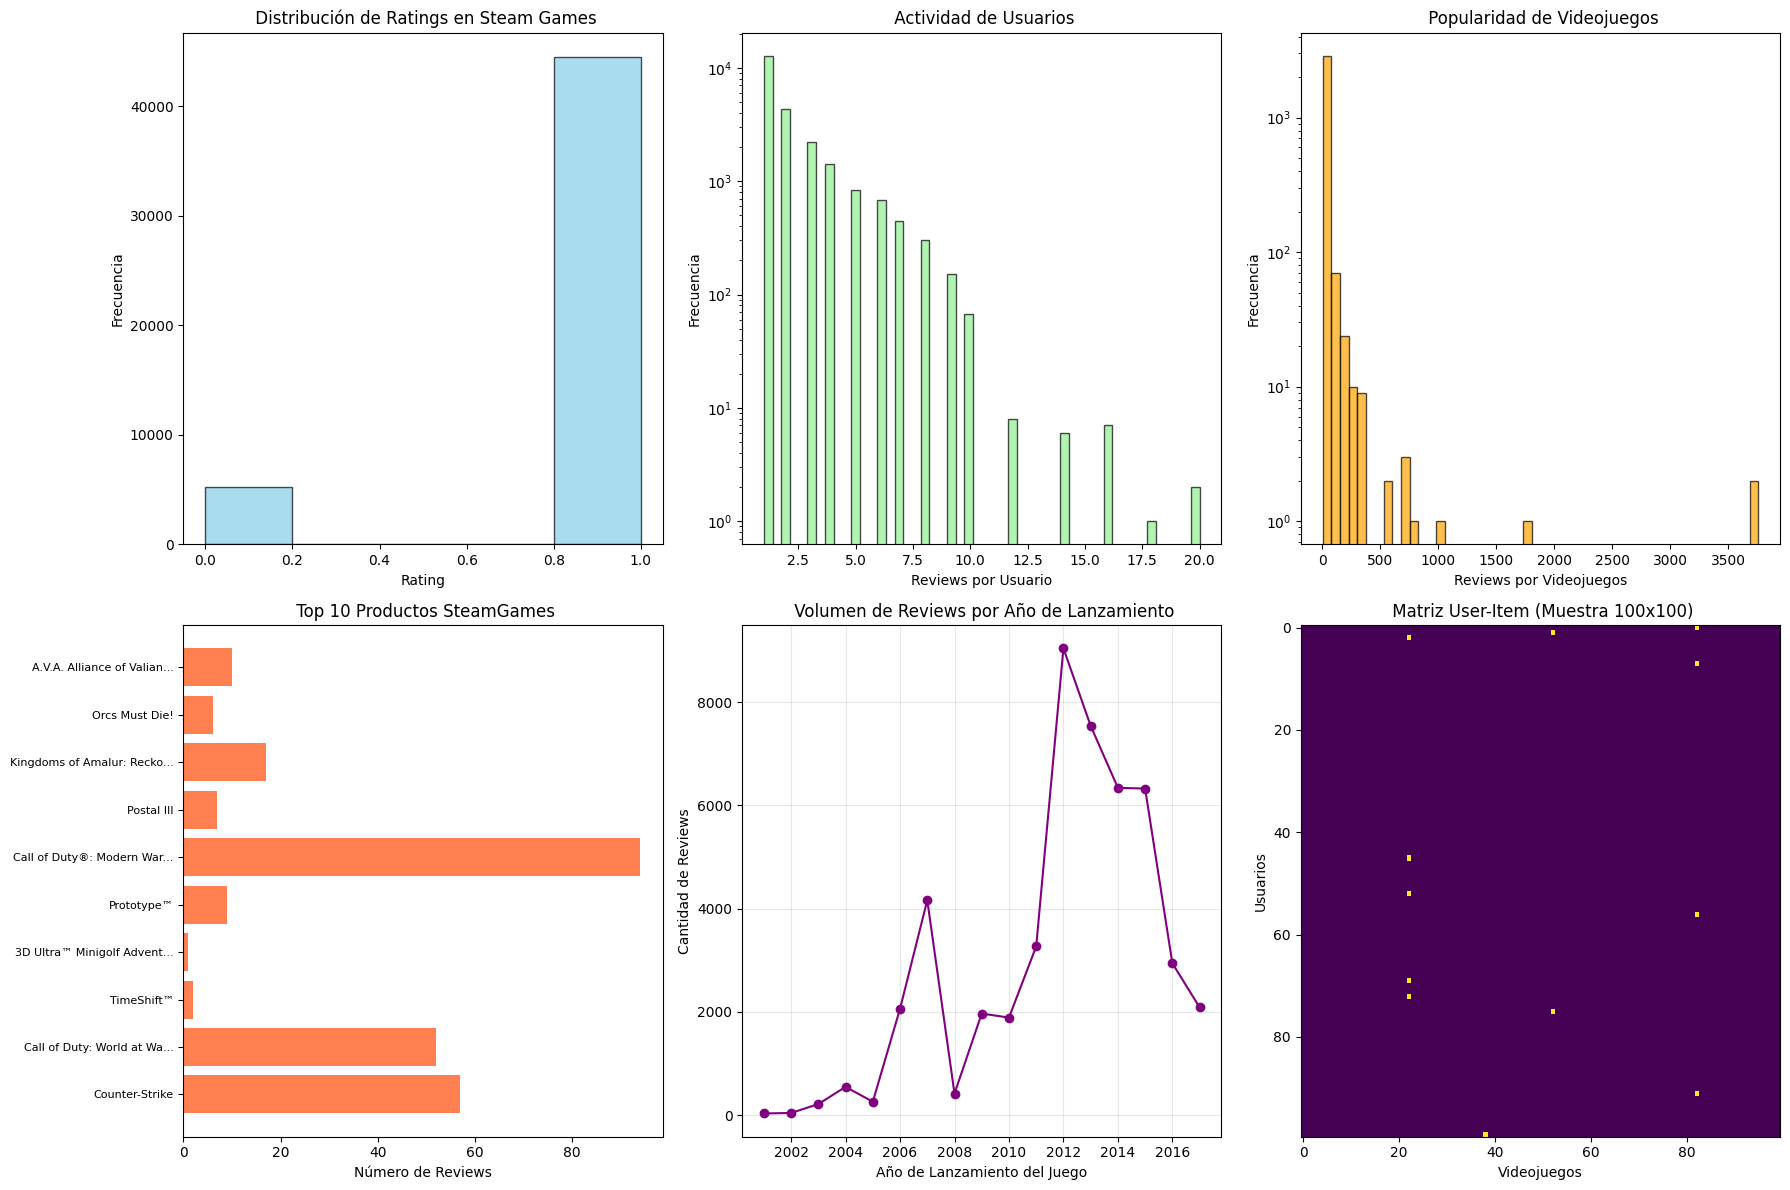

In [20]:
# Visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribución de ratings
axes[0,0].hist(reviews_final['rating'], bins=5, edgecolor='black', alpha=0.7, color='skyblue')
axes[0,0].set_title(' Distribución de Ratings en Steam Games')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frecuencia')

# Actividad de usuarios
axes[0,1].hist(user_activity, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0,1].set_title(' Actividad de Usuarios')
axes[0,1].set_xlabel('Reviews por Usuario')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_yscale('log')

# Popularidad de productos
axes[0,2].hist(item_popularity, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0,2].set_title(' Popularidad de Videojuegos')
axes[0,2].set_xlabel('Reviews por Videojuegos')
axes[0,2].set_ylabel('Frecuencia')
axes[0,2].set_yscale('log')

# Top 10 productos más populares
top_items = item_popularity.head(10)
product_names = []
for item_id in top_items.index:
    title = metadata_final[metadata_final['item_id'] == item_id]['title']
    if not title.empty:
        name = title.iloc[0][:25] + '...' if len(title.iloc[0]) > 25 else title.iloc[0]
    else:
        name = f"Videojuegos {item_id[:8]}"
    product_names.append(name)

axes[1,0].barh(range(len(product_names)), top_items.values, color='coral')
axes[1,0].set_yticks(range(len(product_names)))
axes[1,0].set_yticklabels(product_names, fontsize=8)
axes[1,0].set_title(' Top 10 Productos SteamGames')
axes[1,0].set_xlabel('Número de Reviews')

# Volumen de Reviews por Año de Lanzamiento
metadata_final['year'] = pd.to_datetime(metadata_final['release_date'], errors='coerce').dt.year
reviews_with_year = reviews_final.merge(metadata_final[['item_id', 'year']], on='item_id', how='left')
year_counts = reviews_with_year['year'].value_counts().sort_index()
year_counts = year_counts[year_counts.index > 2000]

axes[1,1].plot(year_counts.index, year_counts.values, marker='o', linestyle='-', color='purple')
axes[1,1].set_title(' Volumen de Reviews por Año de Lanzamiento')
axes[1,1].set_xlabel('Año de Lanzamiento del Juego')
axes[1,1].set_ylabel('Cantidad de Reviews')
axes[1,1].grid(True, alpha=0.3)

# Matriz de sparsity (muestra)
sample_matrix = reviews_final.pivot_table(
    index='user_id', columns='item_id', values='rating', fill_value=0
).iloc[:100, :100]
axes[1,2].imshow(sample_matrix > 0, cmap='viridis', aspect='auto')
axes[1,2].set_title(' Matriz User-Item (Muestra 100x100)')
axes[1,2].set_xlabel('Videojuegos')
axes[1,2].set_ylabel('Usuarios')

plt.tight_layout()
plt.show()

In [21]:
# Calcular sparsity (con validación)
if len(reviews_final) > 0:
    total_users = reviews_final['user_id'].nunique()
    total_items = reviews_final['item_id'].nunique()
    total_ratings = len(reviews_final)
    possible_ratings = total_users * total_items
    sparsity = (1 - total_ratings / possible_ratings) * 100 if possible_ratings > 0 else 0

    print(f"\n ANÁLISIS DE SPARSITY:")
    print(f"    Total posibles ratings: {possible_ratings:,}")
    print(f"    Ratings existentes: {total_ratings:,}")
    print(f"    Sparsity: {sparsity:.2f}%")
else:
    sparsity = 99.0  # Valor por defecto
    print(f"\n Sin datos suficientes para calcular sparsity")


 ANÁLISIS DE SPARSITY:
    Total posibles ratings: 69,127,380
    Ratings existentes: 49,772
    Sparsity: 99.93%


In [22]:
reviews_final.info()
reviews_final.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 49772 entries, 0 to 25798
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      49772 non-null  object
 1   item_id      49772 non-null  object
 2   review_text  49772 non-null  object
 3   recommend    49772 non-null  bool  
 4   rating       49772 non-null  int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 1.9+ MB


,user_id,item_id,review_text,recommend,rating
count,49772,49772,49772,49772,49772.000000
unique,23135,2988,46564,2,NaN
top,76561198064484479,730,good,True,NaN
freq,20,3759,81,44491,NaN
mean,NaN,NaN,NaN,NaN,0.893896
std,NaN,NaN,NaN,NaN,0.307974
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,1.000000


In [23]:
metadata_final.info()
metadata_final.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 2988 entries, 27 to 32117
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   item_id               2988 non-null   object 
 1   publisher             2988 non-null   object 
 2   genres                2988 non-null   object 
 3   title                 2988 non-null   object 
 4   tags                  2988 non-null   object 
 5   specs                 2988 non-null   object 
 6   detailed_description  2988 non-null   object 
 7   release_date          2988 non-null   object 
 8   year                  2976 non-null   float64
dtypes: float64(1), object(8)
memory usage: 233.4+ KB


,item_id,publisher,genres,title,tags,specs,detailed_description,release_date,year
count,2988,2988,2988,2988,2988,2988,2988,2988,2976.000000
unique,2988,1516,380,2988,2921,1038,2911,1619,NaN
top,80,Ubisoft,['Action'],Counter-Strike: Condition Zero,"['Action', 'Adventure']",['Single-player'],,2015-08-27,NaN
freq,1,69,307,1,12,295,78,9,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.594422
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.006779
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1989.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015.000000


## Clase que implementa el modelo

In [24]:
from scipy.sparse import csr_matrix
from langchain_openai import OpenAIEmbeddings
import os
from dotenv import load_dotenv

load_dotenv("/content/env")

class ContentBasedFiltering:
    def __init__(self, metadata_df, ratings_df):
        """
        Sistema de recomendación basado en contenido utilizando Embeddings.

        Parámetros:
        - metadata_df: DataFrame con metadatos de los juegos (título, descripción, tags).
        - ratings_df: DataFrame con las interacciones (reviews) de los usuarios.
        """
        self.metadata_df = metadata_df.copy()
        self.ratings_df = ratings_df
        self.content_matrix = None
        self.item_similarity_matrix = None

        # Cargar modelo de Embeddings
        self.embeddings_model = OpenAIEmbeddings(
            model="text-embedding-3-small",
            openai_api_key=os.getenv("OPENAI_API_KEY")
        )

    def preprocess_content(self):
        """Combina las características de texto del juego en una sola columna"""
        print(">>> Preprocesando características del contenido...")

        def convertir_a_texto(valor):
            if isinstance(valor, list):
                return ' '.join(valor)
            return str(valor) if pd.notna(valor) else ''

        # Limpieza y conversión
        self.metadata_df['title'] = self.metadata_df['title'].apply(convertir_a_texto)
        self.metadata_df['genres'] = self.metadata_df['genres'].apply(convertir_a_texto)
        self.metadata_df['tags'] = self.metadata_df['tags'].apply(convertir_a_texto)
        self.metadata_df['detailed_description'] = self.metadata_df['detailed_description'].apply(convertir_a_texto)

        # Combina todas las caracteristicas del texto
        # Título + Tags + Géneros + Descripción
        self.metadata_df['combined_features'] = (
            self.metadata_df['title'] + ' ' +
            self.metadata_df['tags'] + ' ' +
            self.metadata_df['genres'] + ' ' +
            self.metadata_df['detailed_description']
        ).str.lower().str.replace(r'[^\w\s]', '', regex=True)

        print(f"Características combinadas creadas para {len(self.metadata_df)} juegos.")

    def build_model(self):
        """Genera los embeddings y calcula la matriz de similitud"""

        if 'combined_features' not in self.metadata_df.columns:
            self.preprocess_content()

        print(">>> Generando Embeddings con OpenAI ...")
        # Generar embeddings
        embeddings = self.embeddings_model.embed_documents(self.metadata_df['combined_features'].tolist())
        self.content_matrix = csr_matrix(embeddings)

        print(f"Matriz de Embeddings generada: {self.content_matrix.shape}")

        # Calcular similitud de coseno item-item
        print(">>> Calculando similitudes...")
        self.item_similarity_matrix = linear_kernel(self.content_matrix, self.content_matrix)

        # Mapear cada item_id a un índice numérico y viceversa
        self.item_to_idx = {item_id: idx for idx, item_id in enumerate(self.metadata_df['item_id'])}
        self.idx_to_item = {idx: item_id for item_id, idx in self.item_to_idx.items()}

        print("¡Modelo construido exitosamente!")

    def get_content_similarities(self, item_id, top_k=10):
        """Dado un juego como entrada, encuentra los más parecidos por contenido"""
        if self.item_similarity_matrix is None:
            raise ValueError("El modelo no fue contruido. Ejecute build_model() primero.")

        if item_id not in self.item_to_idx:
            return f"Item {item_id} no encontrado en la metadata"

        idx = self.item_to_idx[item_id]
        similarities = self.item_similarity_matrix[idx]

        # Ignoramos el primero porque es él mismo item
        similar_indices = similarities.argsort()[::-1][1:top_k+1]

        results = []
        for similar_idx in similar_indices:
            similar_item_id = self.idx_to_item[similar_idx]
            similarity_score = similarities[similar_idx]
            results.append({
                'item_id': similar_item_id,
                'similarity': similarity_score
            })

        return results

    def build_user_profile(self, user_id):
        """Crea un vector promedio basado SOLO en juegos que el usuario recomendó (rating=1)"""

        # Filtramos solo lo que el usuario recomendó (True/1)
        user_ratings = self.ratings_df[
            (self.ratings_df['user_id'] == user_id) &
            (self.ratings_df['rating'] == 1)
        ]

        if len(user_ratings) == 0:
            return None

        # Obtener items recomendados
        liked_items = user_ratings['item_id'].tolist()
        liked_indices = [self.item_to_idx[item] for item in liked_items if item in self.item_to_idx]

        if len(liked_indices) == 0:
            return None

        # Peso por calificación y crear perfil de promedio ponderado
        profile_vector = np.zeros(self.content_matrix.shape[1])
        total_weight = 0

        for item_id, rating in zip(user_ratings['item_id'], user_ratings['rating']):
            if item_id in self.item_to_idx:
                idx = self.item_to_idx[item_id]
                weight = rating
                profile_vector += weight * self.content_matrix[idx].toarray().flatten()
                total_weight += weight

        if total_weight > 0:
            profile_vector /= total_weight

        return profile_vector

    def recommend_items(self, user_id, n_recommendations=10, exclude_rated=True):
        """Generar recomendaciones basadas en contenido para un usuario"""
        if self.item_similarity_matrix is None:
            raise ValueError("El modelo no fue contruido. Ejecute build_model() primero.")

        # Crear perfil de usuario
        user_profile = self.build_user_profile(user_id)

        if user_profile is None:
            # Fallback: recomendar juegos populares
            popular_items = (
                self.ratings_df.groupby('item_id')
                .agg({'rating': ['count', 'mean']})
                .round(2)
            )
            popular_items.columns = ['count', 'mean_rating']
            popular_items = popular_items.sort_values(['mean_rating', 'count'], ascending=False)
            return popular_items.head(n_recommendations).reset_index()

        # Calcular similitudes entre el perfil del usuario y todos los items
        profile_similarities = linear_kernel([user_profile], self.content_matrix).flatten()

        # Obtener los elementos que el usuario ha calificado (para exclusión)
        rated_items = set(self.ratings_df[self.ratings_df['user_id'] == user_id]['item_id']) if exclude_rated else set()

        # Crear recomendaciones
        recommendations = []
        for idx, similarity in enumerate(profile_similarities):
            item_id = self.idx_to_item[idx]
            if exclude_rated and item_id in rated_items:
                continue

            recommendations.append({
                'item_id': item_id,
                'similarity_score': similarity,
                'title': self.metadata_df[self.metadata_df['item_id'] == item_id]['title'].iloc[0]
            })

        # Ordenar por similitud
        recommendations = sorted(recommendations, key=lambda x: x['similarity_score'], reverse=True)

        return recommendations[:n_recommendations]

## Construir el modelo

In [25]:
print("CONTENT-BASED FILTERING")
print("="*30)

content_cf = ContentBasedFiltering(metadata_final, reviews_final)
content_cf.build_model()

CONTENT-BASED FILTERING
>>> Preprocesando características del contenido...
Características combinadas creadas para 2988 juegos.
>>> Generando Embeddings con OpenAI ...
Matriz de Embeddings generada: (2988, 1536)
>>> Calculando similitudes...
¡Modelo construido exitosamente!


## Estadísticas

In [26]:
print(f"\nMODEL STATISTICS")
print("-"*20)
print(f"Items in content matrix: {content_cf.content_matrix.shape[0]}")
print(f"Embedding features: {content_cf.content_matrix.shape[1]}")


MODEL STATISTICS
--------------------
Items in content matrix: 2988
Embedding features: 1536


In [27]:
sample_item = metadata_final['item_id'].iloc[5]
sample_item_info = metadata_final[metadata_final['item_id'] == sample_item].iloc[0]
similar_items = content_cf.get_content_similarities(sample_item, 5)

print(f"\nCONTENT-BASED SIMILARITY ANALYSIS:")
print("="*50)
print(f"BASE ITEM: {sample_item}")
print(f"Title: {sample_item_info['title']}")
print(f"Genres: {sample_item_info['genres']}")
print(f"Description: {str(sample_item_info['detailed_description'])[:200]}...")

print(f"\nMOST CONTENT-SIMILAR ITEMS:")
print("-"*40)
for item in similar_items:
    try:
        item_info = metadata_final[metadata_final['item_id'] == item['item_id']].iloc[0]
        avg_rating = reviews_final[reviews_final['item_id'] == item['item_id']]['rating'].mean()
        total_reviews = len(reviews_final[reviews_final['item_id'] == item['item_id']])

        print(f"\nContent Similarity: {item['similarity']:.3f}")
        print(f"  Title: {item_info['title']}")
        print(f"  Genres: {item_info['genres']}")
        print(f"  Description: {str(item_info['detailed_description'])[:120]}...")
        print(f"  Average rating: {avg_rating:.2f}/5 ({total_reviews} reviews)")
    except:
        print(f"  Item {item['item_id']}: {item['similarity']:.3f} (metadata not found)")


CONTENT-BASED SIMILARITY ANALYSIS:
BASE ITEM: 2420
Title: The Ship: Single Player
Genres: ['Action', 'Indie', 'RPG']
Description: For PC gamers who enjoy multiplayer games with a bit of intelligence, intrigue and ingenuity, The Ship is a murder mystery alternative to traditional FPS multiplayer games.  Each player is given a Qua...

MOST CONTENT-SIMILAR ITEMS:
----------------------------------------

Content Similarity: 0.901
  Title: The Ship: Murder Party
  Genres: ['Action', 'Indie', 'RPG']
  Description: Finding a ServerAhoy Shipmates!Unfortunately the in-game server browser is no longer working.  However, players can conn...
  Average rating: 0.96/5 (23 reviews)

Content Similarity: 0.750
  Title: The Ship: Remasted
  Genres: ['Action', 'Indie']
  Description: Now Includes World Leaders!Not only can you play with the original world leaders such as Thatcher, Castro, Blair and Bus...
  Average rating: 0.67/5 (3 reviews)

Content Similarity: 0.638
  Title: The Pirate: Caribbean Hun

In [28]:
# Obtener recomendaciones para un usuario con perfil completo
sample_user = reviews_final['user_id'].iloc[50]
user_history = reviews_final[reviews_final['user_id'] == sample_user]
content_recommendations = content_cf.recommend_items(sample_user, 5)

In [29]:
print(f"\n\nPERFIL DE USUARIO PARA RECOMENDACIONES BASADAS EN CONTENIDO:")
print("="*60)
print(f"USER ID: {sample_user}")
print(f"VideoGame: {metadata_final[metadata_final['item_id'] == user_history['item_id'].iloc[0]].iloc[0].title}")
print(f"Total ratings: {len(user_history)}")
print(f"Average rating: {user_history['rating'].mean():.2f}")

# Analizar las preferencias de categoría del usuario
user_categories = []
high_rated_items = user_history[user_history['rating'] >= 1]
for _, rating_row in high_rated_items.iterrows():
    item_cats = metadata_final[metadata_final['item_id'] == rating_row['item_id']]['tags']
    if not item_cats.empty:
        try:
            cat_value = item_cats.iloc[0]
            if hasattr(cat_value, '__array__') or isinstance(cat_value, (list, tuple)):
                is_valid = len(cat_value) > 0 if hasattr(cat_value, '__len__') else True
            else:
                is_valid = pd.notna(cat_value) and cat_value != ''
            if is_valid:
                cats = str(item_cats.iloc[0]).split(',')
                user_categories.extend([cat.strip() for cat in cats])
        except:
            pass

from collections import Counter
if user_categories:
    top_categories = Counter(user_categories).most_common(3)
    print(f"Preferred categories: {', '.join([f'{cat} ({count})' for cat, count in top_categories])}")

print(f"\nJUEGOS RECOMENDADOS POR EL USUARIO:")
print("-"*40)
for i, (_, rating_row) in enumerate(high_rated_items.head(5).iterrows(), 1):
    try:
        item_info = metadata_final[metadata_final['item_id'] == rating_row['item_id']].iloc[0]
        print(f"{i}. Rating: {rating_row['rating']}")
        print(f"   Title: {item_info['title']}")
        print(f"   Tags: {item_info['tags']}")
    except:
        print(f"{i}. Item {rating_row['item_id']}: {rating_row['rating']}")

print(f"\nRECOMENDACIONES BASADAS EN CONTENIDO PARA EL USUARIO {sample_user}:")
print("="*65)
for i, rec in enumerate(content_recommendations, 1):
    try:
        # Get detailed item information
        item_info = metadata_final[metadata_final['item_id'] == rec['item_id']].iloc[0]
        avg_rating = reviews_final[reviews_final['item_id'] == rec['item_id']]['rating'].mean()
        total_reviews = len(reviews_final[reviews_final['item_id'] == rec['item_id']])

        print(f"\n{i}. SIMILARITY SCORE: {rec['similarity_score']:.3f}")
        print(f"   Item ID: {rec['item_id']}")
        print(f"   Title: {rec['title']}")
        print(f"   Tags: {item_info['tags']}")
        print(f"   Description: {str(item_info['detailed_description'])[:150]}...")
        print(f"   Community rating: {avg_rating:.2f} ({total_reviews} reviews)")

    except Exception as e:
        print(f"\n{i}. {rec['title'][:50]}... - Score: {rec['similarity_score']:.3f}")



PERFIL DE USUARIO PARA RECOMENDACIONES BASADAS EN CONTENIDO:
USER ID: starkillershadow553
VideoGame: Sniper Elite 3
Total ratings: 3
Average rating: 1.00
Preferred categories: 'Multiplayer' (3), 'Shooter' (2), 'Adventure' (2)

JUEGOS RECOMENDADOS POR EL USUARIO:
----------------------------------------
1. Rating: 1
   Title: Sniper Elite 3
   Tags: ['Sniper', 'Action', 'Stealth', 'Multiplayer', 'World War II', 'Shooter', 'Co-op', 'Adventure', 'Third-Person Shooter', 'Tactical', 'Third Person', 'War', 'Singleplayer', 'Online Co-Op', 'Open World', 'Gore', 'Strategy', 'FPS', 'Atmospheric', 'Simulation']
2. Rating: 1
   Title: Vector Thrust
   Tags: ['Action', 'Simulation', 'Flight', 'Indie', 'Arcade', 'Multiplayer', 'Singleplayer']
3. Rating: 1
   Title: Halo: Spartan Assault
   Tags: ['Action', 'Top-Down Shooter', 'Sci-fi', 'Singleplayer', 'Top-Down', 'Shooter', 'Twin Stick Shooter', 'Strategy', 'Touch-Friendly', 'Great Soundtrack', 'Adventure', 'Arcade', 'Futuristic', 'Multiplayer', '